In [2]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import missingno as msno
from sklearn.metrics import classification_report
import ast

In [3]:
import autosklearn.classification

In [4]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: biotech-project-321515


In [22]:
query = """
    SELECT *
    FROM `biotech-project-321515.protein_structure_sequence.dataset_pdb_no_dups`
"""
query_job = client.query(
    query,
    location="US",
)

df = query_job.to_dataframe()
print(df.shape)
df.head(3)

(141401, 14)


,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,5VZL,None,ELECTRON MICROSCOPY,Protein#RNA,1574,3.90,207247.61,None,NaN,NaN,NaN,None,NaN,2017.0
1,1CD1,CD1,X-RAY DIFFRACTION,Protein,828,2.67,95456.59,"VAPOR DIFFUSION, SITTING DROP",NaN,2.19,44.00,6 MG/ML PROTEIN 2.0M (NH4)2SO4 100 MM SODIUM C...,6.5,1997.0
2,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,None,NaN,2.00,38.45,None,NaN,1995.0


In [23]:
df.structureId.nunique()

140911

In [24]:
df.classification.nunique()

5050

In [25]:
dfx = df.drop_duplicates(["structureId"])
dfx.shape

(140911, 14)

In [8]:
dfx = dfx[["classification", "residueCount", "resolution", "resolution", "crystallizationTempK", "densityMatthews", "densityPercentSol", "phValue"]]

<AxesSubplot:>

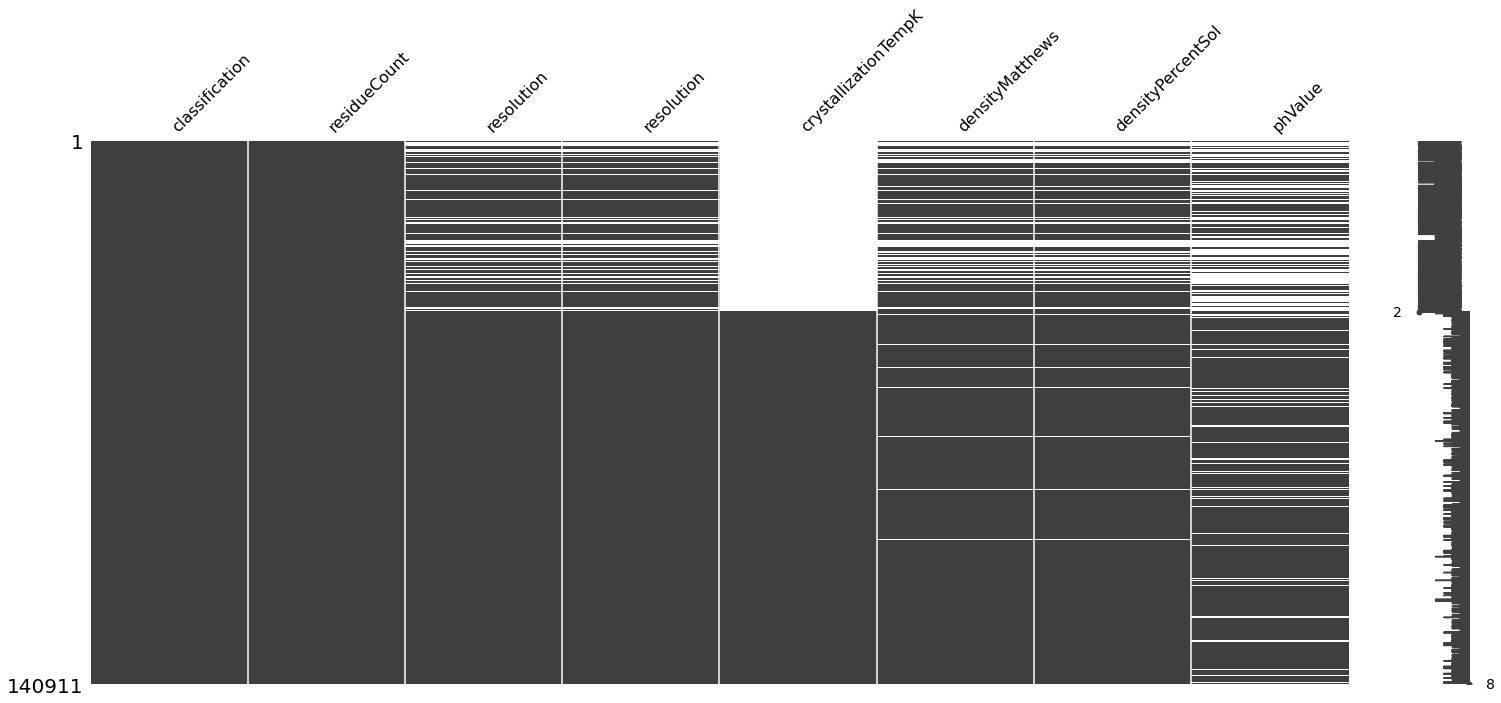

In [9]:
msno.matrix(dfx)

In [14]:
len(dfx.classification.value_counts())

5050

<AxesSubplot:>

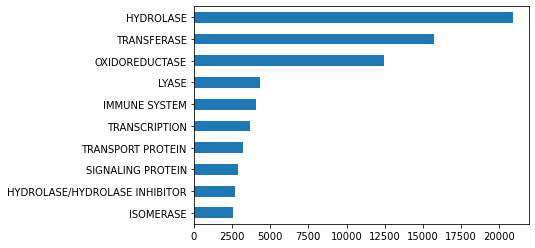

In [15]:
dfx.classification.value_counts()[:10].sort_values().plot(kind = 'barh')

In [40]:
df2 = dfx.groupby("classification").filter(lambda x: len(x) > 14000)
df2.shape

(36594, 14)

In [29]:
df2.classification.value_counts()

HYDROLASE      20872
TRANSFERASE    15722
Name: classification, dtype: int64

<AxesSubplot:>

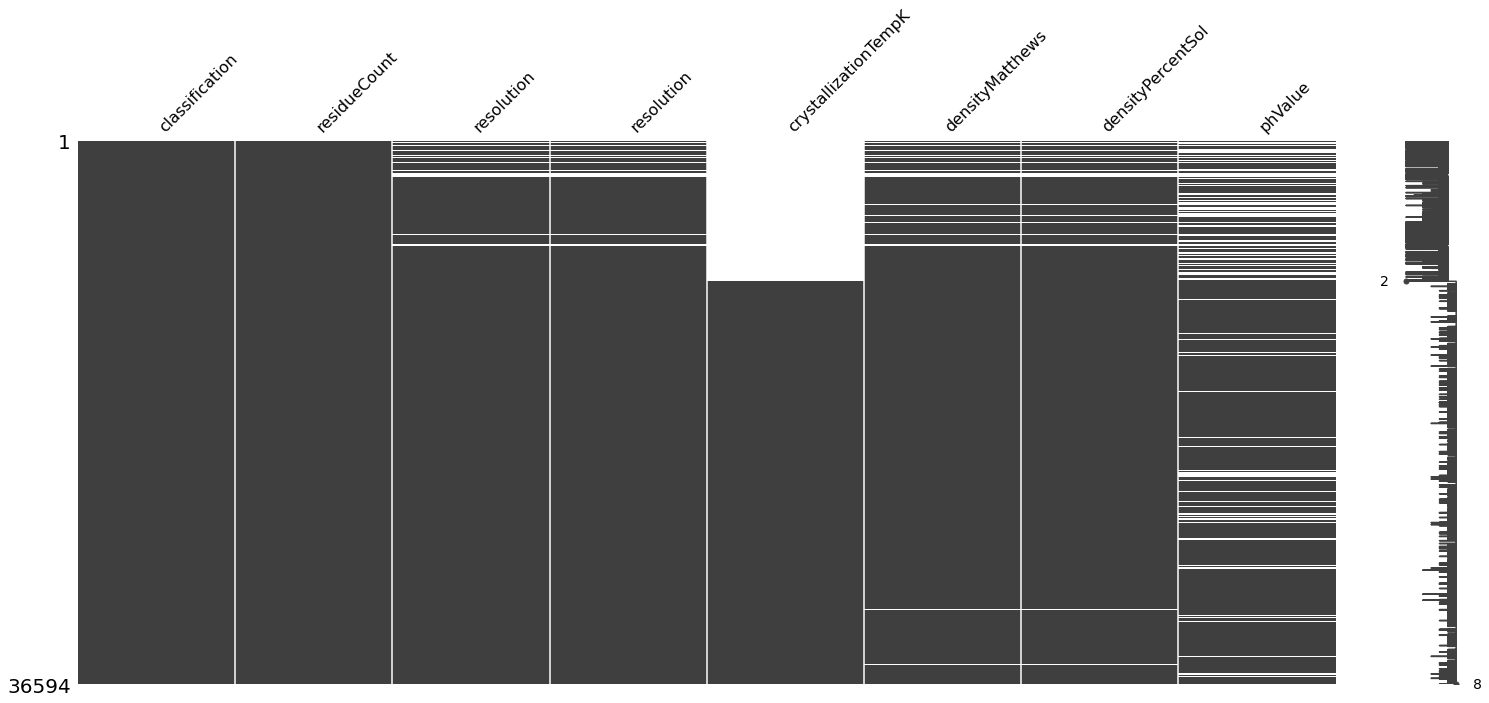

In [18]:
msno.matrix(df2)

In [19]:
df2 = df2.dropna()
df2.shape

(24179, 8)

<AxesSubplot:>

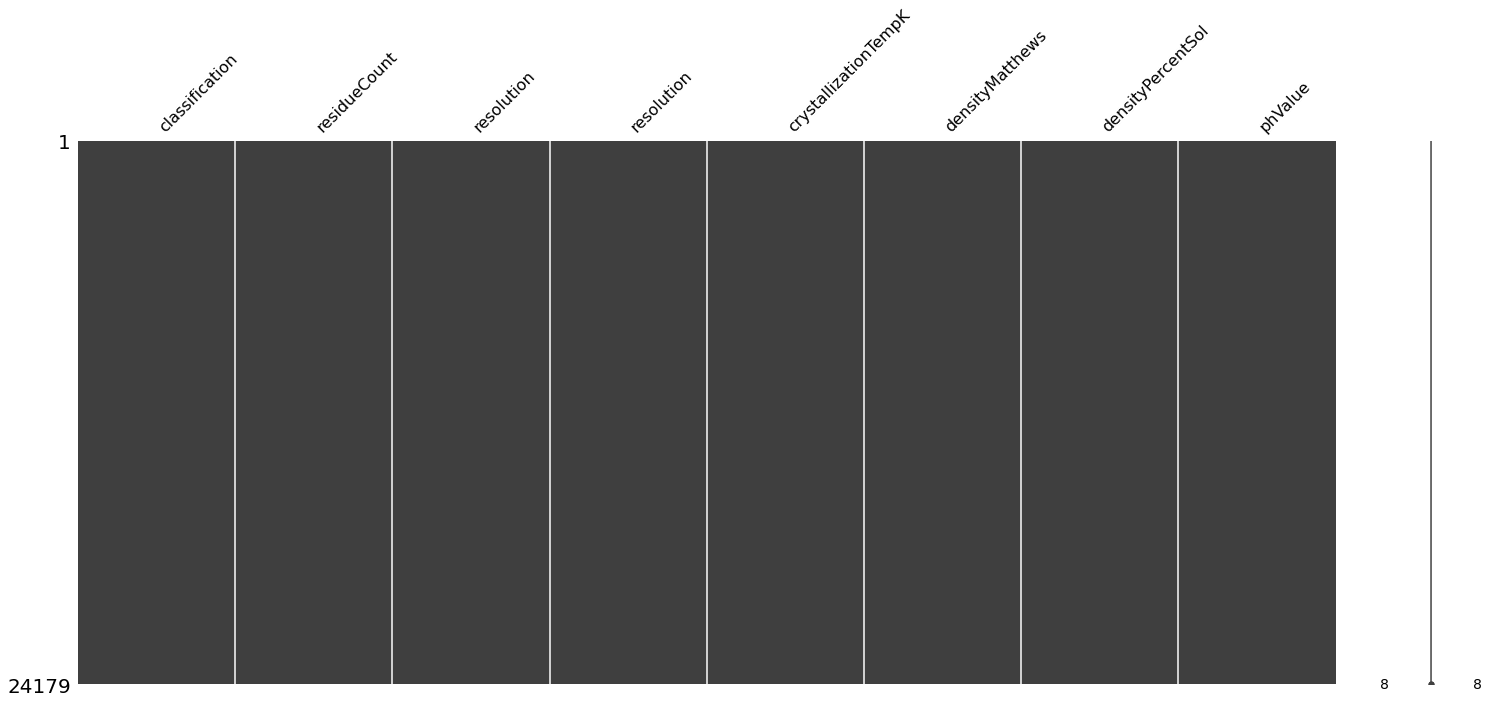

In [20]:
msno.matrix(df2)

In [4]:
query = """
    SELECT classification, count(residueCount) AS classCount
    FROM `biotech-project-321515.protein_structure_sequence.dataset_pdb_no_dups`
    GROUP BY classification
"""
query_job = client.query(
    query,
    location="US",
)

df = query_job.to_dataframe()
df.head(3)

,classification,classCount
0,None,2
1,CD1,1
2,DNA,1765


In [5]:
df.shape

(5051, 2)

In [39]:
query = """
    SELECT DISTINCT
        dups.*
    FROM (
        SELECT classification, count(residueCount) AS classCount
        FROM `biotech-project-321515.protein_structure_sequence.dataset_pdb_no_dups`
        GROUP BY classification
    ) AS sub
    INNER JOIN `biotech-project-321515.protein_structure_sequence.dataset_pdb_no_dups` AS dups
        ON sub.classification = dups.classification
    WHERE sub.classCount > 14000
"""
query_job = client.query(
    query,
    location="US",
)

df2 = query_job.to_dataframe()
print(df.shape)
print(df2.classification.value_counts())
df2.head(3)

(38517, 8)
HYDROLASE      20915
TRANSFERASE    15777
Name: classification, dtype: int64


,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,None,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0
1,11BA,HYDROLASE,X-RAY DIFFRACTION,Protein,248,2.06,28700.28,None,NaN,2.48,50.36,pH 4.8,4.8,1998.0
2,11BG,HYDROLASE,X-RAY DIFFRACTION,Protein,248,1.90,30391.41,None,NaN,2.40,48.68,pH 4.8,4.8,1999.0


In [49]:
df2.shape

(36594, 14)

In [50]:
df2.classification.value_counts()

HYDROLASE      20872
TRANSFERASE    15722
Name: classification, dtype: int64

In [51]:
df2 = df2.drop_duplicates(["structureId"])
df2.shape

(36594, 14)

In [52]:
df2 = df2[["classification", "residueCount", "resolution", "structureMolecularWeight", "crystallizationTempK", "densityMatthews", "densityPercentSol", "phValue"]]

In [53]:
df2 = df2.dropna()
df2.shape

(24179, 8)

<AxesSubplot:>

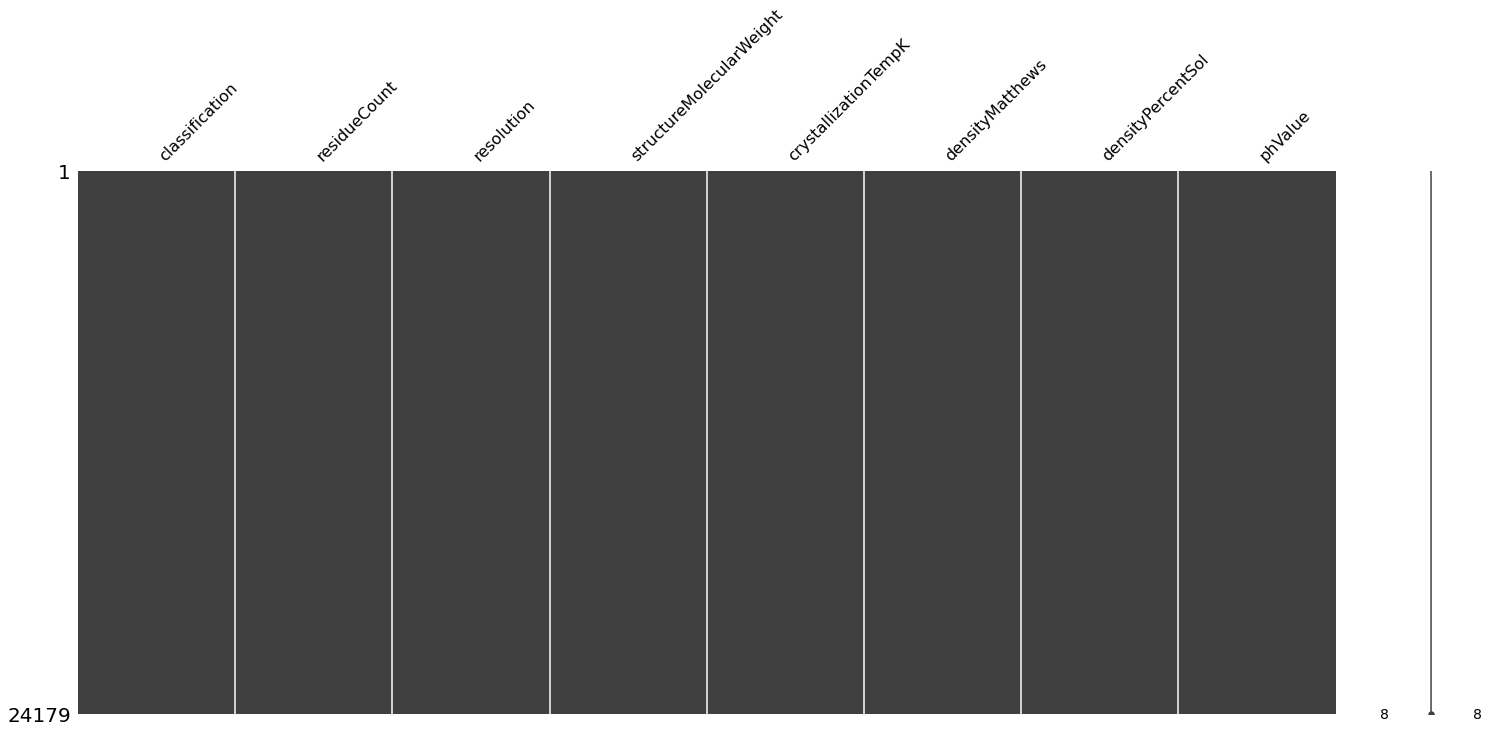

In [54]:
msno.matrix(df2)

In [55]:
import pandas_gbq
pandas_gbq.to_gbq(df2, 'protein_structure_sequence.dataset_pdb_no_dups_cleaned', project_id ='biotech-project-321515', if_exists='replace')

1it [00:05,  5.85s/it]


In [56]:
import autosklearn.classification

In [58]:
X = df2.drop(columns=["classification"])
y = df2.classification.values.ravel()

In [60]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25)

In [18]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder='/tmp/autosklearn_protein_tmp5',
)
automl.fit(X_train, y_train, dataset_name='dataset_pdb_no_dups')

AutoSklearnClassifier(per_run_time_limit=30, time_left_for_this_task=120,
                      tmp_folder='/tmp/autosklearn_protein_tmp5')

In [19]:
print(automl.leaderboard())

          rank  ensemble_weight               type      cost   duration
model_id                                                               
2            1             0.32      random_forest  0.261821  16.188326
3            2             0.08        extra_trees  0.275188  15.251657
10           3             0.22  gradient_boosting  0.288053   9.499943
9            4             0.16      random_forest  0.294737  13.219077
6            5             0.08                mlp  0.397995   3.221838
8            6             0.06         libsvm_svc  0.420217  29.656829
5            7             0.08                mlp  0.421554   9.592515


In [41]:
automl.get_models_with_weights()[0]

(0.32,
 SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'random_forest', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize', 'feature_preprocessor:__choice__': 'no_preprocessing', 'classifier:random_forest:bootstrap': 'True', 'classifier:random_forest:criterion': 'gini', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.5, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 1, 'classifier:random_forest:min_samples_split': 2, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'data_preprocessing:categorical_transfor

In [42]:
print(automl.show_models())

[(0.320000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'random_forest', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize', 'feature_preprocessor:__choice__': 'no_preprocessing', 'classifier:random_forest:bootstrap': 'True', 'classifier:random_forest:criterion': 'gini', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.5, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 1, 'classifier:random_forest:min_samples_split': 2, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'data_preprocessing:categorical_tran

In [20]:
print(automl.show_models())

[(0.320000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'random_forest', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize', 'feature_preprocessor:__choice__': 'no_preprocessing', 'classifier:random_forest:bootstrap': 'True', 'classifier:random_forest:criterion': 'gini', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.5, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 1, 'classifier:random_forest:min_samples_split': 2, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'data_preprocessing:categorical_tran

In [21]:
predictions = automl.predict(X_test)
print("classification_report:", classification_report(y_test, predictions))

classification_report:               precision    recall  f1-score   support

   HYDROLASE       0.75      0.78      0.76      3434
 TRANSFERASE       0.69      0.66      0.67      2611

    accuracy                           0.73      6045
   macro avg       0.72      0.72      0.72      6045
weighted avg       0.73      0.73      0.73      6045

